Steps to follow 
===
1) Question or problem definition.
--
2) Acquire training and testing data. 
--
3) Wrangle, prepare, cleanse the data.
--
4) Analyze, identify patterns, and explore the data.
--
5) Model, predict and solve the problem.
--
6) Visualize, report, and present the problem solving steps and final solution.
--

I Question & Problem Definition
==
We want to create a trading bot which can make decisions : BUY / SELL / HOLD (Classification problem). <br>
To do this we have previously created a database (.csv file) in which we have put different indicators. <br>
With those indicators we expect to be able to predict this decision. <br>
We need to create a pertinent label to predict. <br>
To know : on GDAX the fee on each transaction is 0.3%. <br>

First naive label
--
-1 on each chandelier on which we have a decrease of at least 0.3% <br>
+1 on each chandelier on which we have a increase of at least 0.3% <br>
0 if between -0.3 and 0.3% <br>


II Acquire training and testing data
===
We have done all those steps in another algorithm which is giving us a csv file ouput. <br>
Note : In our dataset we have already solved the problem of NaN values.

III Wrangle, prepare, cleanse the data
===
Once we have import our csv file, we need to create some features that could be useful to our study. <br>

In [1]:
import pandas as pd
import numpy as np
import results
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

file_name = 'btc_eur_3600.csv'
df_primary = pd.read_csv(r'C:\Users\flore\.spyder-py3\trading_bot\btc_eur_3600_290418.csv')


"""Normalisation"""
"""This allows to have all our data on the same scale. To this end it is relevant to compare different chandelier together"""

df_primary['bdb_high_n'] = df_primary['bdb_high'] / df_primary['opening_price']
df_primary['bdb_low_n'] = df_primary['bdb_low'] / df_primary['opening_price']
df_primary['high_price_n'] = df_primary['high_price'] / df_primary['opening_price']
df_primary['low_price_n'] = df_primary['low_price'] / df_primary['opening_price']
df_primary['macd_n'] = df_primary['macd'] / df_primary['opening_price']
df_primary['macd-1'] = df_primary['macd_n'].shift(1)
df_primary['macd-2'] = df_primary['macd_n'].shift(2)
df_primary['macd-3'] = df_primary['macd_n'].shift(3)

"""other variables"""
"""Variation vector creation and its historic in each vector to allow a ML algorithm to see the stock price
previous evolution"""

df_primary['variation'] = (df_primary['closing_price'] - df_primary['opening_price']) / df_primary['opening_price']*100
df_primary['var-1'] = df_primary['variation'].shift(1)
df_primary['var-2'] = df_primary['variation'].shift(2)

"""MACD is one of the most important indicator in stock prices classic analysis, we are creating its derivate, and its 
second derivate to see if there is a correlation with the stock prices"""
df_primary['macd_derivative_n'] = df_primary['macd_n'] - df_primary['macd_n'].shift(1)
df_primary['macd_second_derivative_n'] = df_primary['macd_derivative_n'] - df_primary['macd_derivative_n'].shift(1)

"""Volatility"""
df_primary['volatility'] = df_primary['high_price_n'] - df_primary['low_price_n']
df_primary['derivate_volatility'] = df_primary['volatility'] - df_primary['volatility'].shift(1)
df_primary['derivate_volume'] = df_primary['volume'] - df_primary['volume'].shift(1)

"""redudancy variables dropped"""

df_primary = df_primary.drop('closing_price', axis = 1)
df_primary = df_primary.drop('bdb_low', axis = 1)
df_primary = df_primary.drop('bdb_high', axis = 1)
df_primary = df_primary.drop('mme12', axis = 1)
df_primary = df_primary.drop('mme26', axis = 1)
df_primary = df_primary.drop('opening_price', axis = 1)
df_primary = df_primary.drop('low_price', axis = 1)
df_primary = df_primary.drop('high_price', axis = 1)
df_primary = df_primary.drop('length', axis = 1)
df_primary = df_primary.drop('date', axis = 1)
df_primary = df_primary.drop('macd', axis = 1) 
df_primary = df_primary.drop('timestamp', axis = 1) 

"""On décale d'un cran notre variation afin de pouvoir faire une étude cohérente"""

df_primary['variation'] = df_primary['variation'].shift(-1)

"""label column"""

def label(data_row, seuil = 0.3):
        
    variation = data_row['variation']
    
    if variation >= seuil:
        return 1
    elif variation <= - seuil:
        return -1
    else:
        return 0

df_primary['label'] = df_primary.apply(label, args = (1,), axis=1)
df_training = df_primary.copy()

df_training = df_training.drop('variation', axis = 1) 

"""We drop our NaN which corresponds to the shifted values (3 rows dropped)"""

df_primary.dropna(inplace=True)
df_training.dropna(inplace = True)
df = df_primary.copy()

df_primary.describe()

,volume,stochastic,bdb_high_n,bdb_low_n,high_price_n,low_price_n,macd_n,macd-1,macd-2,macd-3,variation,var-1,var-2,macd_derivative_n,macd_second_derivative_n,volatility,derivate_volatility,derivate_volume,label
count,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5.722000e+03,5.722000e+03,5722.000000,5722.000000,5722.000000,5722.000000
mean,150.678098,0.543759,1.018546,0.981023,1.007890,0.991395,0.001209,0.001209,0.001209,0.001210,0.022829,0.022617,0.022257,8.346488e-08,5.282437e-07,0.016495,-0.000004,0.001194,0.000699
std,189.648471,0.337696,0.032892,0.030012,0.012088,0.013044,0.011618,0.011618,0.011618,0.011619,1.437068,1.437291,1.437229,1.802200e-03,1.395045e-03,0.017526,0.014801,140.538554,0.540284
min,0.000000,0.000000,0.907992,0.781335,1.000000,0.738917,-0.059617,-0.059617,-0.059617,-0.059617,-13.258295,-13.258295,-13.258295,-1.491101e-02,-1.229573e-02,0.000000,-0.262562,-1656.624603,-1.000000
25%,50.893571,0.237793,0.999056,0.968890,1.001093,0.989160,-0.004337,-0.004337,-0.004337,-0.004337,-0.506093,-0.508102,-0.508858,-8.102392e-04,-5.450627e-04,0.006555,-0.005064,-33.164020,0.000000
50%,96.251761,0.568784,1.009075,0.986665,1.004315,0.995493,0.001906,0.001906,0.001906,0.001906,0.030487,0.030728,0.030487,-1.753896e-05,-3.880735e-06,0.011619,-0.000434,-1.998324,0.000000
75%,177.586939,0.859747,1.028797,0.998160,1.009975,0.999001,0.007772,0.007772,0.007776,0.007778,0.545005,0.545005,0.544695,7.793750e-04,5.172757e-04,0.020453,0.004475,26.892461,0.000000
max,3035.870469,1.000000,1.349278,1.162803,1.180557,1.000000,0.048610,0.048610,0.048610,0.048610,14.903178,14.903178,14.903178,1.502293e-02,1.802044e-02,0.328203,0.250463,2146.422002,1.000000


IV Analyze, Identify patterns, and explore the data
==
We need to find some correlations between our features and our label.


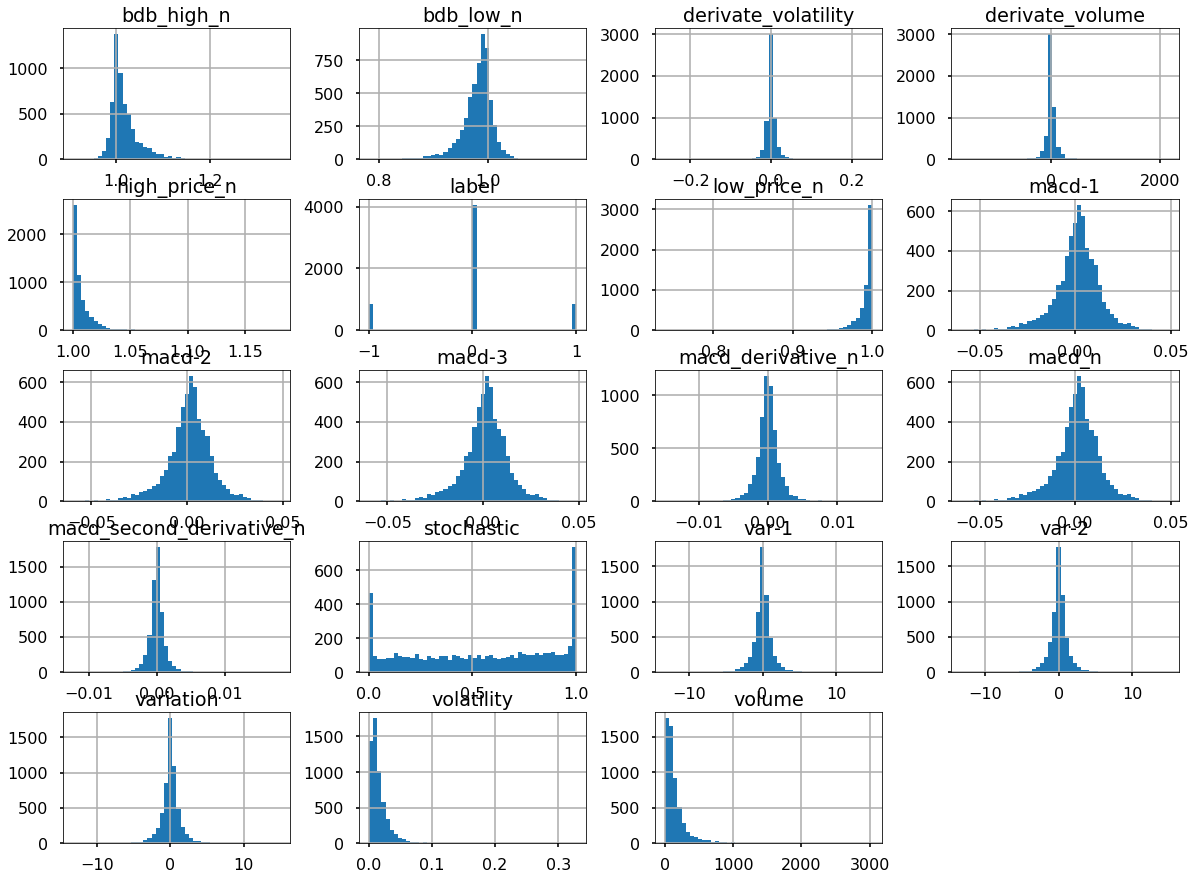

In [2]:
# visualisation of our different parameters
df_primary.hist(bins=50, figsize=(20,15))
plt.show()

In [3]:
# linear correlation with our label
corr_matrix  = df_primary.corr()
corr_matrix['label'].sort_values(ascending=False)

label                       1.000000
variation                   0.800318
macd-3                      0.036730
macd-2                      0.034641
macd-1                      0.030992
macd_n                      0.019725
var-2                       0.018540
derivate_volume             0.012170
volume                      0.009528
stochastic                  0.005389
volatility                 -0.000113
bdb_high_n                 -0.000675
bdb_low_n                  -0.012367
derivate_volatility        -0.018244
var-1                      -0.027799
low_price_n                -0.034708
high_price_n               -0.037615
macd_second_derivative_n   -0.063443
macd_derivative_n          -0.072633
Name: label, dtype: float64

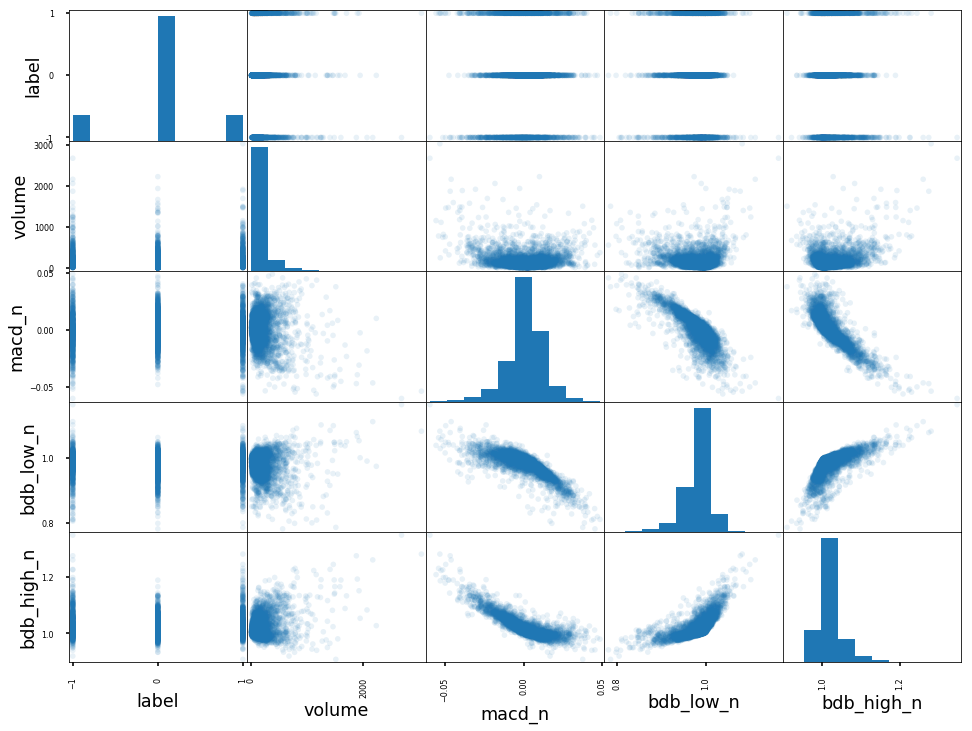

In [4]:
from pandas.plotting import scatter_matrix
"""correlation matrix"""
attributes = ['label', 'volume', 'macd_n', 'bdb_low_n','bdb_high_n']
scatter_matrix(df_primary[attributes], figsize=(16,12), alpha=0.1)
plt.show()

In [5]:
# Creation Testing, training set
X = np.array(df_training.drop('label',1))
y = np.array(df_training['label'])
X_train, X_test, y_train, y_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):], y[:int(len(X)*0.8)], y[int(len(X)*0.8):]


Gain total =  -20.08 %.
Nombre de transactions =  62
Argent dépensé en commissions =  15.24 %.
Nombre de chandeliers sans cash engagé =  794
Nombre de chandeliers sur lesquels on a juste hold =  289


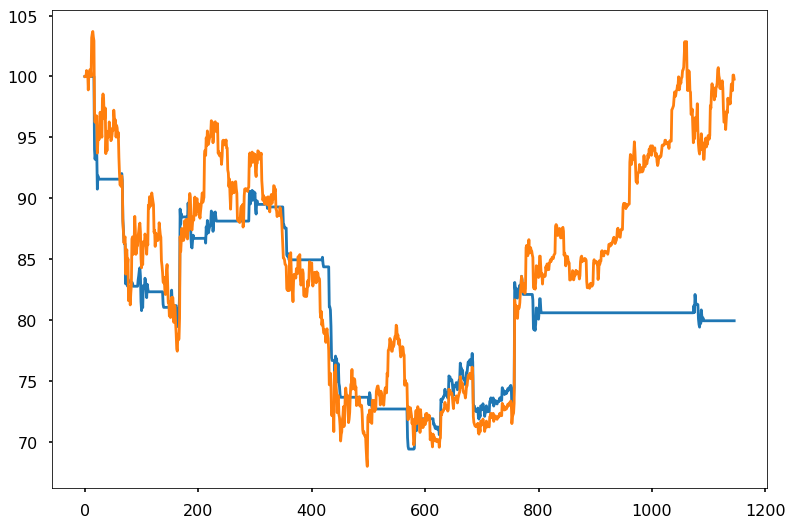

C:\Users\flore\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\flore\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


                        Model   Score
3               Random Forest  100.00
0     Support Vector Machines   84.99
1                         KNN   76.91
2         Logistic Regression   69.99
8               Decision Tree   69.99
6  Stochastic Gradient Decent   69.00
4                 Naive Bayes   68.65
7                  Linear SVC   61.86
5                  Perceptron   19.11


,Model,Score
2,Logistic Regression,77.38
8,Decision Tree,77.38
0,Support Vector Machines,76.94
6,Stochastic Gradient Decent,76.07
3,Random Forest,75.72
4,Naive Bayes,74.24
1,KNN,67.25
7,Linear SVC,66.20
5,Perceptron,14.85


In [6]:
# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Useful to create the market_prices list
dh = df.iloc[4577:,:]

# Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test).tolist()

# Score
score = clf.score(X_train, y_train)

market_prices = dh['variation'].values.tolist()

decisions_results = results.strategy_based_results(predictions, market_prices, fee_rate = 0.3)
market_var = results.buy_hold_results(market_prices)
L = [i for i in range(len(decisions_results))]

# Results display
plt.plot(L, decisions_results)
plt.plot(L, market_var)
plt.show()

# Bokeh graph
label = dh['label'].values.tolist()
results.plot_strategy_with_labels(label, predictions, decisions_results, notebook=False)

# Logreg
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)


# Support Vector Machines
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)


# kNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)


# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)

# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)


# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)


# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)


# Decision Tree
decision_tree = LogisticRegression()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)


# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)


models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
print(models.sort_values(by='Score', ascending=False))

# Logreg
acc_log_test = round(logreg.score(X_test, y_test) * 100, 2)


# Support Vector Machines
acc_svc_test = round(svc.score(X_test, y_test) * 100, 2)


# kNN
acc_knn_test = round(knn.score(X_test, y_test) * 100, 2)


# Gaussian Naive Bayes
acc_gaussian_test = round(gaussian.score(X_test, y_test) * 100, 2)

# Perceptron
acc_perceptron_test = round(perceptron.score(X_test, y_test) * 100, 2)


# Linear SVC
acc_linear_svc_test = round(linear_svc.score(X_test, y_test) * 100, 2)


# Stochastic Gradient Descent
acc_sgd_test = round(sgd.score(X_test, y_test) * 100, 2)


# Decision Tree
acc_decision_tree_test = round(decision_tree.score(X_test, y_test) * 100, 2)


# Random Forest
acc_random_forest_test = round(random_forest.score(X_test, y_test) * 100, 2)


test_models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc_test, acc_knn_test, acc_log_test, 
              acc_random_forest_test, acc_gaussian_test, acc_perceptron_test, 
              acc_sgd_test, acc_linear_svc_test, acc_decision_tree_test]})
test_models.sort_values(by='Score', ascending=False)